<a href="https://colab.research.google.com/github/manuelapop/demo_dataset/blob/main/dataset_jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using data file: /content/TemplateTargetingJobs.json
Saved cleaned CSV to: ./job_dataset_clean.csv


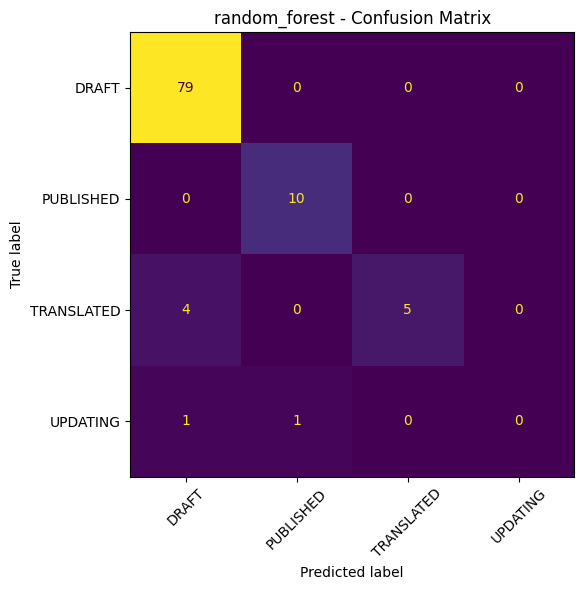

<Figure size 640x480 with 0 Axes>

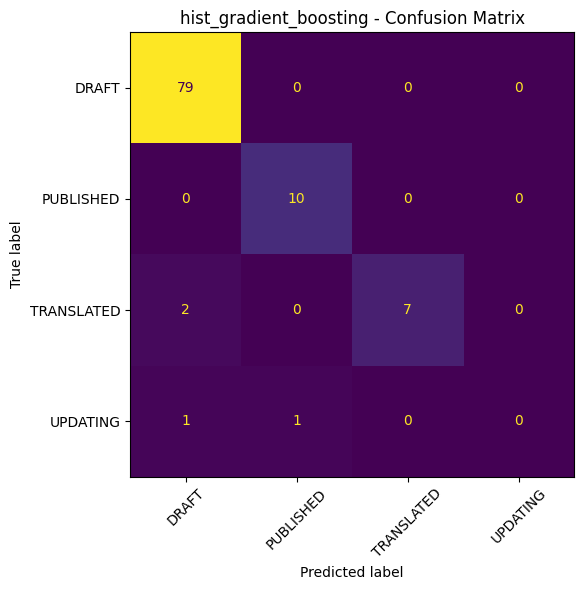

Best model: hist_gradient_boosting | RF macro-F1=0.6600 | HGB macro-F1=0.7000
Report: ./hist_gradient_boosting_classification_report.txt
Confusion Matrix image: ./hist_gradient_boosting_confusion_matrix.png


<Figure size 640x480 with 0 Axes>

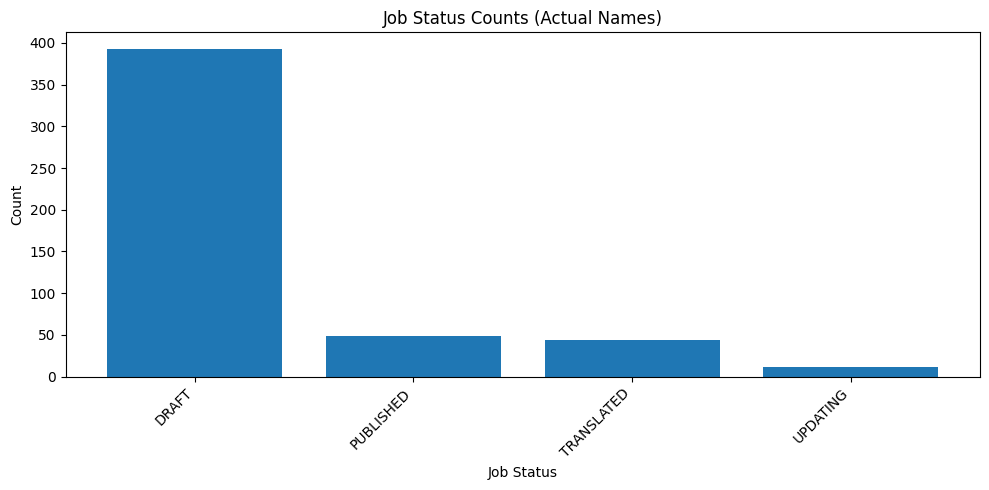

Saved: ./job_status_counts_actual_matplotlib.png


<Figure size 640x480 with 0 Axes>

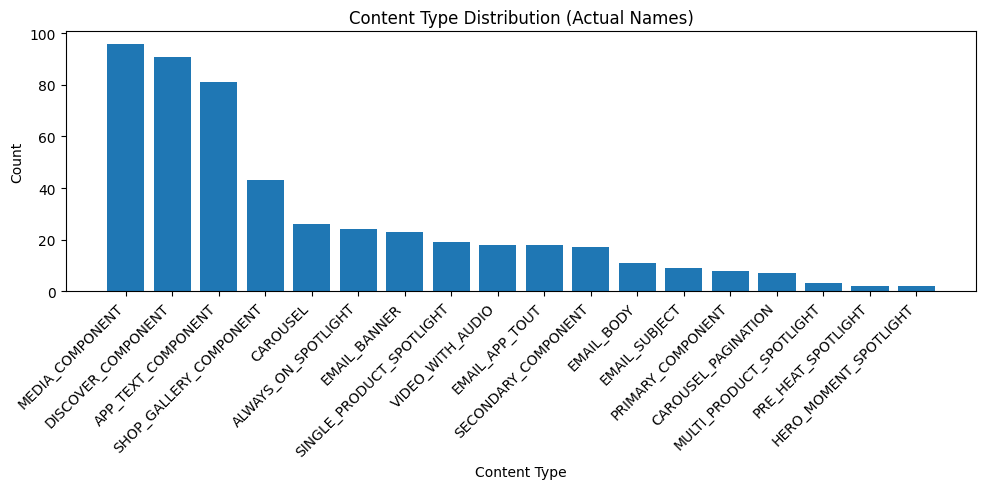

Saved: ./content_type_distribution_actual_matplotlib.png


<Figure size 640x480 with 0 Axes>

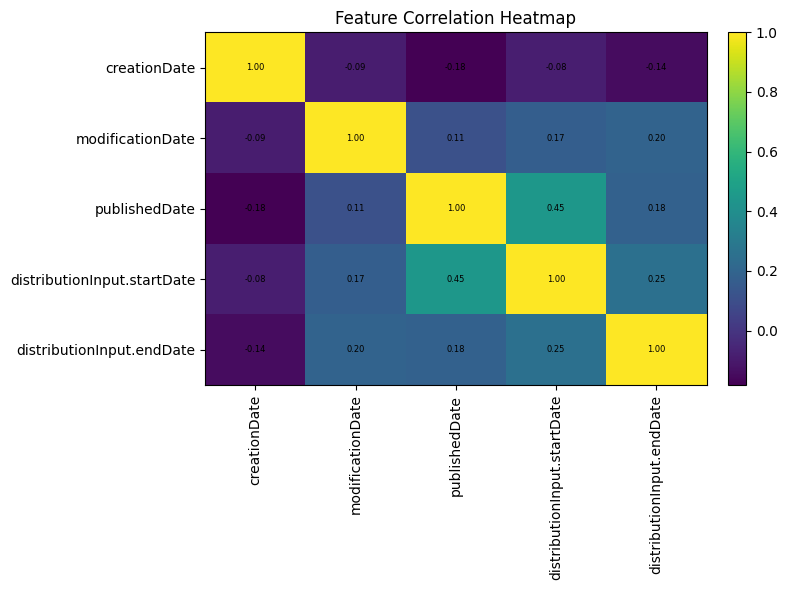

Saved: ./correlation_heatmap_matplotlib.png
Example single-row prediction: {'predicted_status': 'PUBLISHED', 'proba': {'DRAFT': 0.0001, 'PUBLISHED': 0.9599, 'TRANSLATED': 0.04, 'UPDATING': 0.0}, 'model_used': 'hist_gradient_boosting'}


<Figure size 640x480 with 0 Axes>

In [ ]:
# ===============================================
# TemplateTargetingJobs end-to-end:
# - Robust JSON loader
# - Date conversion (no .view())
# - OneHotEncoder with version-safe arg
# - RF + HGB; pick best by macro-F1
# - Saves plots/reports
# - predict_one(new_job) helper
# ===============================================

import os, json, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# -----------------------------
# 0) Locate your JSON file
# -----------------------------
CANDIDATE_PATHS = [
    "/mnt/data/TemplateTargetingJobs (1).json",  # sandbox path (this chat environment)
    "/mnt/data/TemplateTargetingJobs.json",
    "/content/TemplateTargetingJobs (1).json",   # common Colab paths
    "/content/TemplateTargetingJobs.json",
    "TemplateTargetingJobs (1).json",            # local / repo
    "TemplateTargetingJobs.json",
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find TemplateTargetingJobs JSON. Set DATA_PATH to your file location."
    )
print(f"Using data file: {DATA_PATH}")

# -----------------------------
# 1) Load JSON -> jobs
# -----------------------------
with open(DATA_PATH, "r") as f:
    raw = json.load(f)

if isinstance(raw, dict) and "data" in raw and "templateTargetingJobs" in raw["data"]:
    jobs = raw["data"]["templateTargetingJobs"]["jobs"]
elif isinstance(raw, dict) and "templateTargetingJobs" in raw:
    jobs = raw["templateTargetingJobs"]["jobs"]
elif isinstance(raw, dict) and "jobs" in raw:
    jobs = raw["jobs"]
else:
    jobs = raw  # assume list of jobs

df = pd.json_normalize(jobs)

# -----------------------------
# 2) Human-readable copies for plots
# -----------------------------
for col in ["status", "contentType"]:
    df[f"{col}_name"] = df.get(col, "Unknown")

# -----------------------------
# 3) Convert date strings -> epoch seconds (no .view())
# -----------------------------
date_cols = [
    "creationDate",
    "modificationDate",
    "publishedDate",
    "distributionInput.startDate",
    "distributionInput.endDate",
]
for c in date_cols:
    if c in df.columns:
        dt = pd.to_datetime(df[c], errors="coerce", utc=True)
        df[c] = (dt.astype("int64") // 10**9).astype("float").fillna(0.0)

# -----------------------------
# 4) Fill common string cols
# -----------------------------
for c in ["contentType", "createdBy", "modifiedBy", "publishedBy", "status", "name", "id"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str)

# Remove rows with missing status (after fill they'd be "Unknown")
df = df[df["status"] != "Unknown"].copy()

# Save a cleaned snapshot
OUT_DIR = "/mnt/data" if os.path.exists("/mnt/data") else "."
CLEAN_CSV = os.path.join(OUT_DIR, "job_dataset_clean.csv")
df.to_csv(CLEAN_CSV, index=False)
print(f"Saved cleaned CSV to: {CLEAN_CSV}")

# -----------------------------
# 5) Features / Target
# -----------------------------
X = df.drop(columns=[c for c in ["status", "status_name", "contentType_name"] if c in df.columns])
y = df["status"]

# Drop leaky / very high-cardinality identifiers from features
for leak in ["id", "name"]:
    if leak in X.columns:
        X = X.drop(columns=[leak])

# Split columns into categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# -----------------------------
# 6) Train/Test split (stratify if possible)
# -----------------------------
stratify_arg = y if y.nunique() > 1 and y.value_counts().min() >= 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_arg
)

# -----------------------------
# 7) Preprocessor (OneHot with version-safe arg) + Models
# -----------------------------
# OneHotEncoder renamed 'sparse' -> 'sparse_output' in newer sklearn (>=1.2)
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)),
])

hgb = Pipeline([
    ("prep", preprocess),
    ("model", HistGradientBoostingClassifier(random_state=42)),
])

def train_eval(pipe, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rep_text = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))

    # Save report
    rep_path = os.path.join(OUT_DIR, f"{name}_classification_report.txt")
    with open(rep_path, "w") as f:
        f.write(rep_text)

    # Save confusion matrix plot (matplotlib)
    fig = plt.figure(figsize=(7, 6))
    ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique())).plot(
        include_values=True, xticks_rotation=45, ax=plt.gca(), colorbar=False
    )
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    cm_path = os.path.join(OUT_DIR, f"{name}_confusion_matrix.png")
    plt.show()
    plt.savefig(cm_path)
    plt.close(fig)

    return rep_text, rep_path, cm_path

rf_text, rf_rep, rf_cm = train_eval(rf, "random_forest")
hgb_text, hgb_rep, hgb_cm = train_eval(hgb, "hist_gradient_boosting")

def macro_f1_from_text(text: str) -> float:
    for line in text.splitlines():
        if line.strip().startswith("macro avg"):
            parts = [p for p in line.split(" ") if p.strip()]
            nums = [float(p) for p in parts if p.replace(".", "", 1).isdigit()]
            if len(nums) >= 3:
                return nums[2]  # precision, recall, f1
    return 0.0

rf_macro_f1 = macro_f1_from_text(rf_text)
hgb_macro_f1 = macro_f1_from_text(hgb_text)

best_name, best_pipe, best_rep_path, best_cm_path = (
    ("hist_gradient_boosting", hgb, hgb_rep, hgb_cm)
    if hgb_macro_f1 >= rf_macro_f1
    else ("random_forest", rf, rf_rep, rf_cm)
)

print(f"Best model: {best_name} | RF macro-F1={rf_macro_f1:.4f} | HGB macro-F1={hgb_macro_f1:.4f}")
print(f"Report: {best_rep_path}")
print(f"Confusion Matrix image: {best_cm_path}")

# -----------------------------
# 8) Quick EDA plots (matplotlib-only)
# -----------------------------
# Status counts
if "status_name" in df.columns:
    fig = plt.figure(figsize=(10, 5))
    vc = pd.Series(df["status_name"]).value_counts()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Job Status Counts (Actual Names)")
    plt.xlabel("Job Status"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    STATUS_PNG = os.path.join(OUT_DIR, "job_status_counts_actual_matplotlib.png")
    plt.show();plt.savefig(STATUS_PNG); plt.close(fig)
    print(f"Saved: {STATUS_PNG}")

# Content type counts
if "contentType_name" in df.columns:
    fig = plt.figure(figsize=(10, 5))
    vc = pd.Series(df["contentType_name"]).value_counts()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Content Type Distribution (Actual Names)")
    plt.xlabel("Content Type"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    CONTENT_PNG = os.path.join(OUT_DIR, "content_type_distribution_actual_matplotlib.png")
    plt.show();plt.savefig(CONTENT_PNG); plt.close(fig)
    print(f"Saved: {CONTENT_PNG}")

# Correlation heatmap for numeric columns
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    fig = plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Feature Correlation Heatmap")
    # annotate cells
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            val = corr.iloc[i, j]
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=6)
    plt.tight_layout()
    CORR_PNG = os.path.join(OUT_DIR, "correlation_heatmap_matplotlib.png")
    plt.show();plt.savefig(CORR_PNG); plt.close(fig)
    print(f"Saved: {CORR_PNG}")

# -----------------------------
# 9) Helpers for safe date conversion & single-record prediction
# -----------------------------
def _to_epoch_seconds(x) -> float:
    """
    Accepts ISO string / pandas Timestamp / number / None.
    Returns seconds since epoch (float). Non-parsable -> 0.0
    """
    if x is None:
        return 0.0
    if isinstance(x, (int, float)):
        # assume already seconds-since-epoch if numeric
        return float(x)
    dt = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(dt):
        return 0.0
    # dt.value is an int (ns since epoch); divide to seconds
    return float(dt.value // 10**9)

def predict_one(new_job: dict) -> dict:
    """
    Pass a dict with any subset of known fields (strings for categoricals, ISO date strings for date fields).
    Missing fields default to 'Unknown' (categoricals) or 0.0 (numerics).
    Returns predicted status, optional class probabilities, and the model used.
    """
    # Build one-row frame matching X's columns
    row = {}
    for c in X.columns:
        row[c] = new_job.get(c, ("Unknown" if c in cat_cols else 0.0))
    one = pd.DataFrame([row])

    # Convert date fields robustly (works for strings, Timestamps, numbers, None)
    for c in date_cols:
        if c in one.columns:
            one.loc[0, c] = _to_epoch_seconds(one.loc[0, c])

    # Predict
    pred = best_pipe.predict(one)[0]
    proba = None
    try:
        proba_vec = best_pipe.predict_proba(one)[0]
        classes = list(best_pipe.classes_)
        proba = dict(zip(classes, [float(f"{p:.4f}") for p in proba_vec]))
    except Exception:
        pass  # some estimators don't support predict_proba

    return {"predicted_status": str(pred), "proba": proba, "model_used": best_name}

# -----------------------------
# 10) Example new record prediction
# -----------------------------
example_new = {
    "contentType": "EMAIL_BANNER",
    "createdBy": "Manuela.Pop@nike.com",
    "modifiedBy": "Manuela.Pop@nike.com",
    "publishedBy": None,
    "creationDate": "2025-10-15T12:00:00Z",
    "modificationDate": "2025-10-15T13:00:00Z",
    "publishedDate": None,
    "distributionInput.startDate": "2025-10-29T00:00:00Z",
    "distributionInput.endDate": None,
    # "id" and "name" intentionally not in X to avoid leakage
}
print("Example single-row prediction:", predict_one(example_new))
